In [1]:
import os
import torch
import random
import sys

import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

from collections import deque
from matplotlib import cm
from torch import autocast, GradScaler
from scipy.linalg import expm
from qutip import Bloch, Qobj

GPU Management

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device.type

'cuda'

In [3]:
!set 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:2'
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [4]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
torch.cuda.empty_cache()

In [5]:
print("__Python VERSION:", sys.version)
print("__pyTorch VERSION:", torch.__version__)

__Python VERSION: 3.12.7 (main, Oct 20 2024, 15:05:48) [GCC 13.2.0]
__pyTorch VERSION: 2.5.1+cu124


In [6]:
print("__CUDA VERSION")
!nvidia-smi

__CUDA VERSION
Sun Nov 17 10:22:53 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti     Off |   00000000:01:00.0  On |                  N/A |
| N/A   57C    P5              8W /   50W |     625MiB /   4096MiB |     19%      Default |
|                                         |                        |                  N/A |
+--------------------------------

In [7]:
print("__CUDNN VERSION:", torch.backends.cudnn.version())
!nvcc --version

__CUDNN VERSION: 90100
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Wed_Aug_14_10:10:22_PDT_2024
Cuda compilation tools, release 12.6, V12.6.68
Build cuda_12.6.r12.6/compiler.34714021_0


In [8]:
print("__Number CUDA Devices:", torch.cuda.device_count())
print("__Devices")
print("Available devices ", torch.cuda.device_count())
print("Active CUDA Device: GPU", torch.cuda.current_device())

__Number CUDA Devices: 1
__Devices
Available devices  1
Active CUDA Device: GPU 0


In [9]:
# Hyperparameters
LEARNING_RATE = 1e-4
GAMMA = 0.9
EPSILON = 1.0
EPSILON_DECAY = 0.95
MIN_EPSILON = 0.0001
MEMORY_SIZE = 10000
BATCH_SIZE = 512
TARGET_UPDATE = 10
EPISODES = 200000
PATIENCE = EPISODES / 2
MAX_STEPS = 10
FIDELITY_THRESHOLD = 1e-5

# Define Pauli matrices
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

# Define Hamiltonian parameters
omega = 1.0
J = 0.1

# Define Gates
HADAMARD = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
T_GATE = np.array([[1, 0], [0, np.exp(1j * np.pi / 4)]], dtype=np.complex128)
CNOT = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])

In [10]:
class QuantumGateEnv:
    """
    A class to represent the environment for quantum gate control
    using reinforcement learning.

    Attributes:
    ----------
    gate : str
        The type of quantum gate (e.g., 'H', 'T', 'CNOT').
    control_pulse_params : dict
        Dictionary containing amplitude, phase, and duration parameters
        for control pulses.
    initial_state : np.ndarray
        The initial quantum state of the system.
    state : np.ndarray
        The current quantum state of the system.
    target : np.ndarray
        The target quantum gate matrix.
    theoretical_state : np.ndarray
        The expected quantum state after applying the target gate.
    time_step : int
        The current time step in the episode.
    max_steps : int
        The maximum number of steps in an episode.
    state_history : list
        A history of quantum states during an episode.
    """

    def __init__(self, gate):
        """
        Initializes the QuantumGateEnv with the specified gate type.

        Parameters:
        ----------
        gate : str
            The type of quantum gate (e.g., 'H', 'T', 'CNOT').
        """
        self.control_pulse_params = {
            "amplitude": np.linspace(0, 1, 10),  # Example amplitudes
            "phase": np.linspace(0, 2 * np.pi, 12),  # Example phases
            "duration": np.linspace(0.1, 1, 10),  # Example durations
        }
        self.gate = gate
        (
            self.initial_state,
            self.target_state,
            self.state_size,
            self.action_size,
            self.input_features,
            self.hidden_features,
            self.epsilon_decay,
        ) = self.set_quantum_info()
        self.reset()

    def set_quantum_info(self):
        """
        Sets the quantum information for the environment based on the gate type.

        Returns:
        -------
        tuple
            A tuple containing the initial state, target_state, state size,
            action size, and input features.
        """
        action_size = (
            len(self.control_pulse_params["amplitude"])
            * len(self.control_pulse_params["phase"])
            * len(self.control_pulse_params["duration"])
        )

        if self.gate in ["H", "T"]:
            num_qubits = 1
            state_size = 2**num_qubits
            # initial_states = [
            #     np.array([1, 0], dtype=np.complex128),
            #     np.array([0, 1], dtype=np.complex128),
            # ]
            # initial_state = random.choice(initial_states)
            phi = np.random.uniform(0, 2 * np.pi)         # Azimuthal angle
            cos_theta = np.random.uniform(-1, 1)          # Uniform distribution for cos(theta)
            theta = np.arccos(cos_theta)                  # Polar angle
            alpha = np.cos(theta / 2)
            beta = np.exp(1j * phi) * np.sin(theta / 2)
            initial_state = np.array([alpha, beta], dtype=np.complex128)
            input_features = 2 ** (
                num_qubits + 1
            )  # Number of states in the input space
            hidden_features = 512
            epsilon_decay = 0.95
            unitary = HADAMARD if self.gate == "H" else T_GATE
            target_state = np.dot(initial_state, unitary)

        elif self.gate == "CNOT":
            num_qubits = 2
            state_size = 2**num_qubits
            initial_states = [
                np.array([1, 0, 0, 0], dtype=np.complex128),
                np.array([0, 1, 0, 0], dtype=np.complex128),
                np.array([0, 0, 1, 0], dtype=np.complex128),
                np.array([0, 0, 0, 1], dtype=np.complex128),
            ]
            initial_state = random.choice(initial_states)
            input_features = 2 ** (
                num_qubits + 1
            )  # Number of states in the input space
            hidden_features = 512
            epsilon_decay = 0.99
            unitary = CNOT
            target_state = np.dot(initial_state, unitary)

        return (
            initial_state,
            target_state,
            state_size,
            action_size,
            input_features,
            hidden_features,
            epsilon_decay,
        )

    def reset(self):
        """
        Resets the environment to the initial state.

        Returns:
        -------
        np.ndarray
            The initial quantum state.
        """
        self.state = self.initial_state.copy()
        self.time_step = 0
        self.max_steps = MAX_STEPS
        self.reward_episode = [-1]
        self.fidelity_episode = [0]
        self.state_episode = [self.state]
        self.amplitude_episode = [0]
        self.phase_episode = [0]
        self.duration_episode = [0]
        return self.state

    def _time_evolution_operator(self, H, t):
        """
        Compute the time evolution operator U(t) = exp(-i * H * t).

        Parameters:
        H (ndarray): The Hamiltonian matrix.
        t (float): The time over which to evolve the system.

        Returns:
        ndarray: The time evolution operator U(t).
        """
        return expm(-1j * H * t)

    def _construct_hamiltonian(self, amplitude, phase):
        """
        Constructs the Hamiltonian for the quantum gate operation based on the gate type.

        Parameters:
        ----------
        amplitude : float
            The amplitude of the control Hamiltonian, which modulates the strength of the control fields.
        phase : float
            The phase of the control Hamiltonian, which determines the direction of the control field in the XY-plane.

        Returns:
        -------
        H_total : ndarray
            The total Hamiltonian (system + control) for the specified gate operation.
            If the gate is "H" or "T", returns a 2x2 matrix.
            If the gate is "CNOT", returns a 4x4 matrix.
        """
        if self.gate in ["H", "T"]:
            H_sys = (omega / 2) * Z  # System Hamiltonian (static)
            H_control = amplitude * (
                np.cos(phase) * X + np.sin(phase) * Y
            )  # Control Hamiltonian (depends on amplitude and phase)
            return H_sys + H_control  # Total Hamiltonian
        elif self.gate == "CNOT":
            H_system = (
                (omega / 2) * np.kron(Z, I)
                + (omega / 2) * np.kron(I, Z)
                + J * (np.kron(X, X) + np.kron(Y, Y))
            )  # System Hamiltonian (static)
            H_control = amplitude * (
                np.kron(X, I) * np.cos(phase) + np.kron(Y, I) * np.sin(phase)
            )  # Control Hamiltonian (depends on amplitude and phase)
            return H_system + H_control  # Total Hamiltonian

    def infidelity(self, final_state):
        """
        Calculates the infidelity between the final state and the theoretical state.

        Parameters:
        ----------
        final_state (np.ndarray): The final quantum state after applying the control pulse.

        Returns:
        -------
        float
            The infidelity between the final state and the theoretical state.
        """
        fidelity = np.abs(np.dot(np.conjugate(self.target_state), final_state)) ** 2
        return 1 - fidelity

    def step(self, action):
        """
        Takes a step in the environment using the given action.

        Parameters:
        ----------
        action : int
        The action to be taken by the agent.

        Returns:
        -------
        tuple
        A tuple containing the next state, reward, and done flag.
        """
        self.time_step += 1

        num_phases = len(self.control_pulse_params["phase"])
        num_durations = len(self.control_pulse_params["duration"])

        amplitude_index = action // (num_phases * num_durations)
        phase_index = (action // num_durations) % num_phases
        duration_index = action % num_durations

        amplitude = self.control_pulse_params["amplitude"][amplitude_index]
        phase = self.control_pulse_params["phase"][phase_index]
        duration = self.control_pulse_params["duration"][duration_index]

        control_hamiltonian = self._construct_hamiltonian(amplitude, phase)
        control_matrix = self._time_evolution_operator(control_hamiltonian, duration)

        next_state = np.dot(control_matrix, self.state)
        self.state = next_state

        # Store episode
        self.state_episode.append(self.state)
        self.amplitude_episode.append(amplitude)
        self.phase_episode.append(phase)
        self.duration_episode.append(duration)

        reward = -self.infidelity(next_state) if self.time_step == self.max_steps else 0
        fidelity = 1 + reward
        self.reward_episode.append(reward)
        self.fidelity_episode.append(fidelity)
        done = self.time_step == self.max_steps

        return (
            done,
            next_state,
            amplitude,
            phase,
            duration,
            reward,
            fidelity,
        )

In [11]:
# Deep Q-Network
class DQN(nn.Module):
    def __init__(self, state_size, action_size, dropout=0.1):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(env.input_features, env.hidden_features)
        self.fc2 = nn.Linear(env.hidden_features, env.hidden_features)
        self.fc3 = nn.Linear(env.hidden_features, env.action_size)
        self.dropout = nn.Dropout(dropout)
        self._initialize_weights()

    def forward(self, state):
        x = self.dropout(torch.relu(self.fc1(state)))
        x = self.dropout(torch.relu(self.fc2(x)))
        return self.fc3(x)

    def _initialize_weights(self):
        def init_weights(layer):
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, nonlinearity="relu")
                nn.init.zeros_(layer.bias)
        self.apply(init_weights)

In [12]:
# Replay Memory
class ReplayMemory:
    """
    A class to represent replay memory for storing experiences during reinforcement learning.

    Attributes:
    ----------
    memory : deque
        A deque to store the experiences with a fixed maximum length.
    """

    def __init__(self, capacity):
        """
        Initializes the replay memory with a specified capacity.

        Parameters:
        ----------
        capacity : int
            The maximum number of experiences the memory can hold.
        """
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        """
        Adds an experience to the replay memory.

        Parameters:
        ----------
        state : np.ndarray
            The state observed before taking the action.
        action : int
            The action taken by the agent.
        reward : float
            The reward received after taking the action.
        next_state : np.ndarray
            The state observed after taking the action.
        done : bool
            Whether the episode has ended.
        """
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        """
        Samples a batch of experiences from the replay memory.

        Parameters:
        ----------
        batch_size : int
            The number of experiences to sample.

        Returns:
        -------
        list
            A list of sampled experiences.
        """
        return random.sample(self.memory, batch_size)

    def __len__(self):
        """
        Returns the current size of the replay memory.

        Returns:
        -------
        int
            The number of experiences currently stored in the replay memory.
        """
        return len(self.memory)

In [13]:
# DQN Agent
class DQNAgent:
    """
    A DQN agent for reinforcement learning in quantum gate control.

    Attributes:
    ----------
    state_size : int
        The size of the state space.
    action_size : int
        The size of the action space.
    epsilon : float
        The exploration rate for the epsilon-greedy policy.
    memory : ReplayMemory
        The replay memory to store experiences.
    model : DQN
        The Q-network model for learning the Q-values.
    target_model : DQN
        The target Q-network model for stable learning.
    optimizer : torch.optim.Adam
        The optimizer for training the model.
    scaler : torch.cuda.amp.GradScaler
        The gradient scaler for mixed precision training.
    loss : torch.nn.MSELoss
        The loss function for training the model.
    """

    def __init__(self, state_size, action_size):
        """
        Initializes the DQN Agent with the given state and action sizes.

        Parameters:
        ----------
        state_size : int
            The size of the state space.
        action_size : int
            The size of the action space.
        """
        self.state_size = state_size
        self.action_size = action_size
        self.epsilon = EPSILON
        self.memory = ReplayMemory(MEMORY_SIZE)
        self.model = DQN(state_size, action_size).to(device)
        self.target_model = DQN(state_size, action_size).to(device)
        self.optimizer = optim.Adam(
            self.model.parameters(),
            lr=LEARNING_RATE,
            amsgrad=True,
            weight_decay=LEARNING_RATE * 0.1,
        )
        self.scaler = GradScaler(device=device.type)
        self.update_target_model()
        self.loss = nn.MSELoss().to(device)

    def update_target_model(self):
        """
        Updates the target model by copying the weights from the current model.
        """
        self.target_model.load_state_dict(self.model.state_dict())

    def act(self, state):
        """
        Selects an action using the epsilon-greedy policy.

        Parameters:
        ----------
        state : np.ndarray
            The current state.

        Returns:
        -------
        int
            The action selected by the agent.
        """
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = (
            torch.FloatTensor(np.concatenate([state.real, state.imag]))
            .unsqueeze(0)
            .to(device)
        )
        q_vals = self.model(state)
        return torch.argmax(q_vals).item()

    def remember(self, state, action, reward, next_state, done):
        """
        Stores an experience in the replay memory.

        Parameters:
        ----------
        state : np.ndarray
            The state before taking the action.
        action : int
            The action taken by the agent.
        reward : float
            The reward received after taking the action.
        next_state : np.ndarray
            The state after taking the action.
        done : bool
            Whether the episode has ended.
        """
        self.memory.push(state, action, reward, next_state, done)

    def replay(self):
        """
        Trains the model by replaying a batch of experiences from the replay memory.
        """
        if len(self.memory) < BATCH_SIZE:
            return
        batch = self.memory.sample(BATCH_SIZE)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(
            np.array([np.concatenate([s.real, s.imag]) for s in states])
        ).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(
            np.array([np.concatenate([s.real, s.imag]) for s in next_states])
        ).to(device)
        dones = torch.FloatTensor(dones).to(device)

        with autocast(device_type=device.type):
            Q_targets_next = self.target_model(next_states).detach().max(1)[0]
            Q_targets = rewards + (GAMMA * Q_targets_next * (1 - dones))
            Q_expected = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
            loss = self.loss(Q_expected, Q_targets)

        self.optimizer.zero_grad(set_to_none=True)
        self.scaler.scale(loss).backward()
        self.scaler.step(self.optimizer)
        self.scaler.update()

        if self.epsilon > MIN_EPSILON:
            self.epsilon *= env.epsilon_decay

In [ ]:
# Training the agent
def train_agent(agent, env, episodes, target_update, fidelity_threshold, patience):
    """
    Trains a reinforcement learning agent in a specified environment over a series of episodes.

    Parameters:
    -----------
    agent : object
        The reinforcement learning agent to be trained. The agent must have the methods `act(state)`, `remember(state, action, reward, next_state, done)`, `replay()`, and `update_target_model()` implemented.
    env : object
        The environment in which the agent is trained. The environment must have the methods `reset()`, `step(action)`, and `infidelity(state)` implemented, as well as the attribute `max_steps`.
    episodes : int
        The number of training episodes.
    target_update : int
        The frequency (in episodes) at which the agent's target model is updated.
    fidelity_threshold : float
        The fidelity threshold for early stopping. Training will stop early if the best fidelity achieved is greater than or equal to `1 - fidelity_threshold`.
    patience : int
        The patience parameter for early stopping. If fidelity does not improve for this many consecutive episodes, training will stop early.

    Returns:
    --------
    rewards : list of float
        A list containing the total rewards obtained in each episode.
    fidelities : list of float
        A list containing the fidelities achieved in each episode, where fidelity is defined as `1 - infidelity`.
    state_history : list
        A list of final states from each episode.
    amplitudes_history : list
        A list containing the amplitudes recorded at each episode step.
    phases_history : list
        A list containing the phases recorded at each episode step.
    durations_history : list
        A list containing the durations recorded at each episode step.

    Notes:
    ------
    - Early stopping is triggered if the best fidelity exceeds `1 - fidelity_threshold` or if the fidelity does not improve for `patience` consecutive episodes.
    - The method assumes that the environment's `step` method returns `next_state, reward, done, amplitudes, phases, durations`.
    """
    reward_history = []
    fidelity_history = []
    state_history = []
    amplitude_history = []
    phase_history = []
    duration_history = []
    best_fidelity = 0
    patience_counter = 0

    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        for _ in range(env.max_steps):
            action = agent.act(state)
            (done, next_state, amplitude, phase, duration, reward, fidelity) = env.step(
                action
            )
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                break
        agent.replay()

        if e % target_update == 0:
            agent.update_target_model()

        state_history.append(state)
        amplitude_history.append(amplitude)
        phase_history.append(phase)
        duration_history.append(duration)
        reward_history.append(total_reward)
        fidelity_history.append(fidelity)

        if e % (EPISODES / 100) == 0:
            print(
                f"Episode: {e}/{episodes},  Reward: {total_reward:.5f}, "
                f"Fidelity: {fidelity_history[-1]:.5f},  Epsilon: {agent.epsilon:.5f}"
            )
        # Early stopping check
        current_fidelity = 1 - env.infidelity(state)
        if current_fidelity >= best_fidelity:
            best_fidelity = current_fidelity
            patience_counter = 0  # Reset patience counter if fidelity improves
        else:
            patience_counter += 1

        if best_fidelity >= (1 - fidelity_threshold) or patience_counter >= patience:
            print(
                f"Early stopping triggered. Achieved fidelity: {best_fidelity:.5f}, "
                f"Episode: {e}, Patience: {patience_counter}, Reward: {total_reward:.5f}, "
                f"Epsilon: {agent.epsilon:.5f}"
            )
            break

    print("Training finished.")
    return (
        reward_history,
        fidelity_history,
        state_history,
        amplitude_history,
        phase_history,
        duration_history,
    )

In [15]:
def plot_results(
    rewards, fidelities, amplitudes, phases, durations, last_episode=False
):
    """
    Plots the results of the training process, including rewards,
    fidelities, and control pulse parameters.

    Parameters:
    ----------
    rewards : list
        A list of rewards per episode.
    fidelities : list
        A list of fidelities per episode.
    amplitudes : list
        A list of amplitudes of control pulses per episode.
    phases : list
        A list of phases of control pulses per episode.
    durations : list
        A list of durations of control pulses per episode.
    last_episode : bool, optional
        If True, indicates that the data is from the last episode only.
        In this case, the x-axis will not be logarithmic.
    """
    data = [
        (rewards, "Reward per Episode", "Reward"),
        (fidelities, "Fidelity per Episode", "Fidelity"),
        (amplitudes, "Amplitude per Episode", "Amplitude", "r"),
        (phases, "Phase per Episode", "Phase", "g"),
        (durations, "Duration per Episode", "Duration", "b"),
    ]

    plt.figure(figsize=(15, 20))

    for i, (data_series, label, ylabel, *color) in enumerate(data):
        plt.subplot(5, 1, i + 1)
        plt.plot(data_series, label=label, color=color[0] if color else None)

        # Apply log scale if not last episode and data is long enough
        if not last_episode:
            plt.xscale("log")

        plt.xlabel("Episode" if not last_episode else "Step")
        plt.ylabel(ylabel)
        plt.legend()
        plt.grid()

    plt.tight_layout()
    plt.show()

In [16]:
def plot_bloch_sphere_trajectory(states):
    bloch = Bloch()
    # Add states
    for state in states:
        bloch.add_states(Qobj(state))
    bloch.show()
    plt.show()

H-Gate

In [17]:
# Initialize environment and agent
env = QuantumGateEnv(gate='H')
agent = DQNAgent(env.state_size, env.action_size)

In [18]:
# Compile the model (requires PyTorch 2.0 or later)
if torch.__version__ >= "2.0.0":
    agent.model = torch.compile(agent.model)
    agent.target_model = torch.compile(agent.target_model)

In [19]:
# Train the agent
(
    reward_history,
    fidelity_history,
    state_history,
    amplitude_history,
    phase_history,
    duration_history,
) = train_agent(agent, env, EPISODES, TARGET_UPDATE, FIDELITY_THRESHOLD, PATIENCE)

-0.775328885119813
Episode: 0/200000,  Reward: -0.77533, Fidelity: 0.22467,  Epsilon: 1.00000
-0.7003470808163472
Episode: 2000/200000,  Reward: -0.70035, Fidelity: 0.29965,  Epsilon: 0.00010


KeyboardInterrupt: 

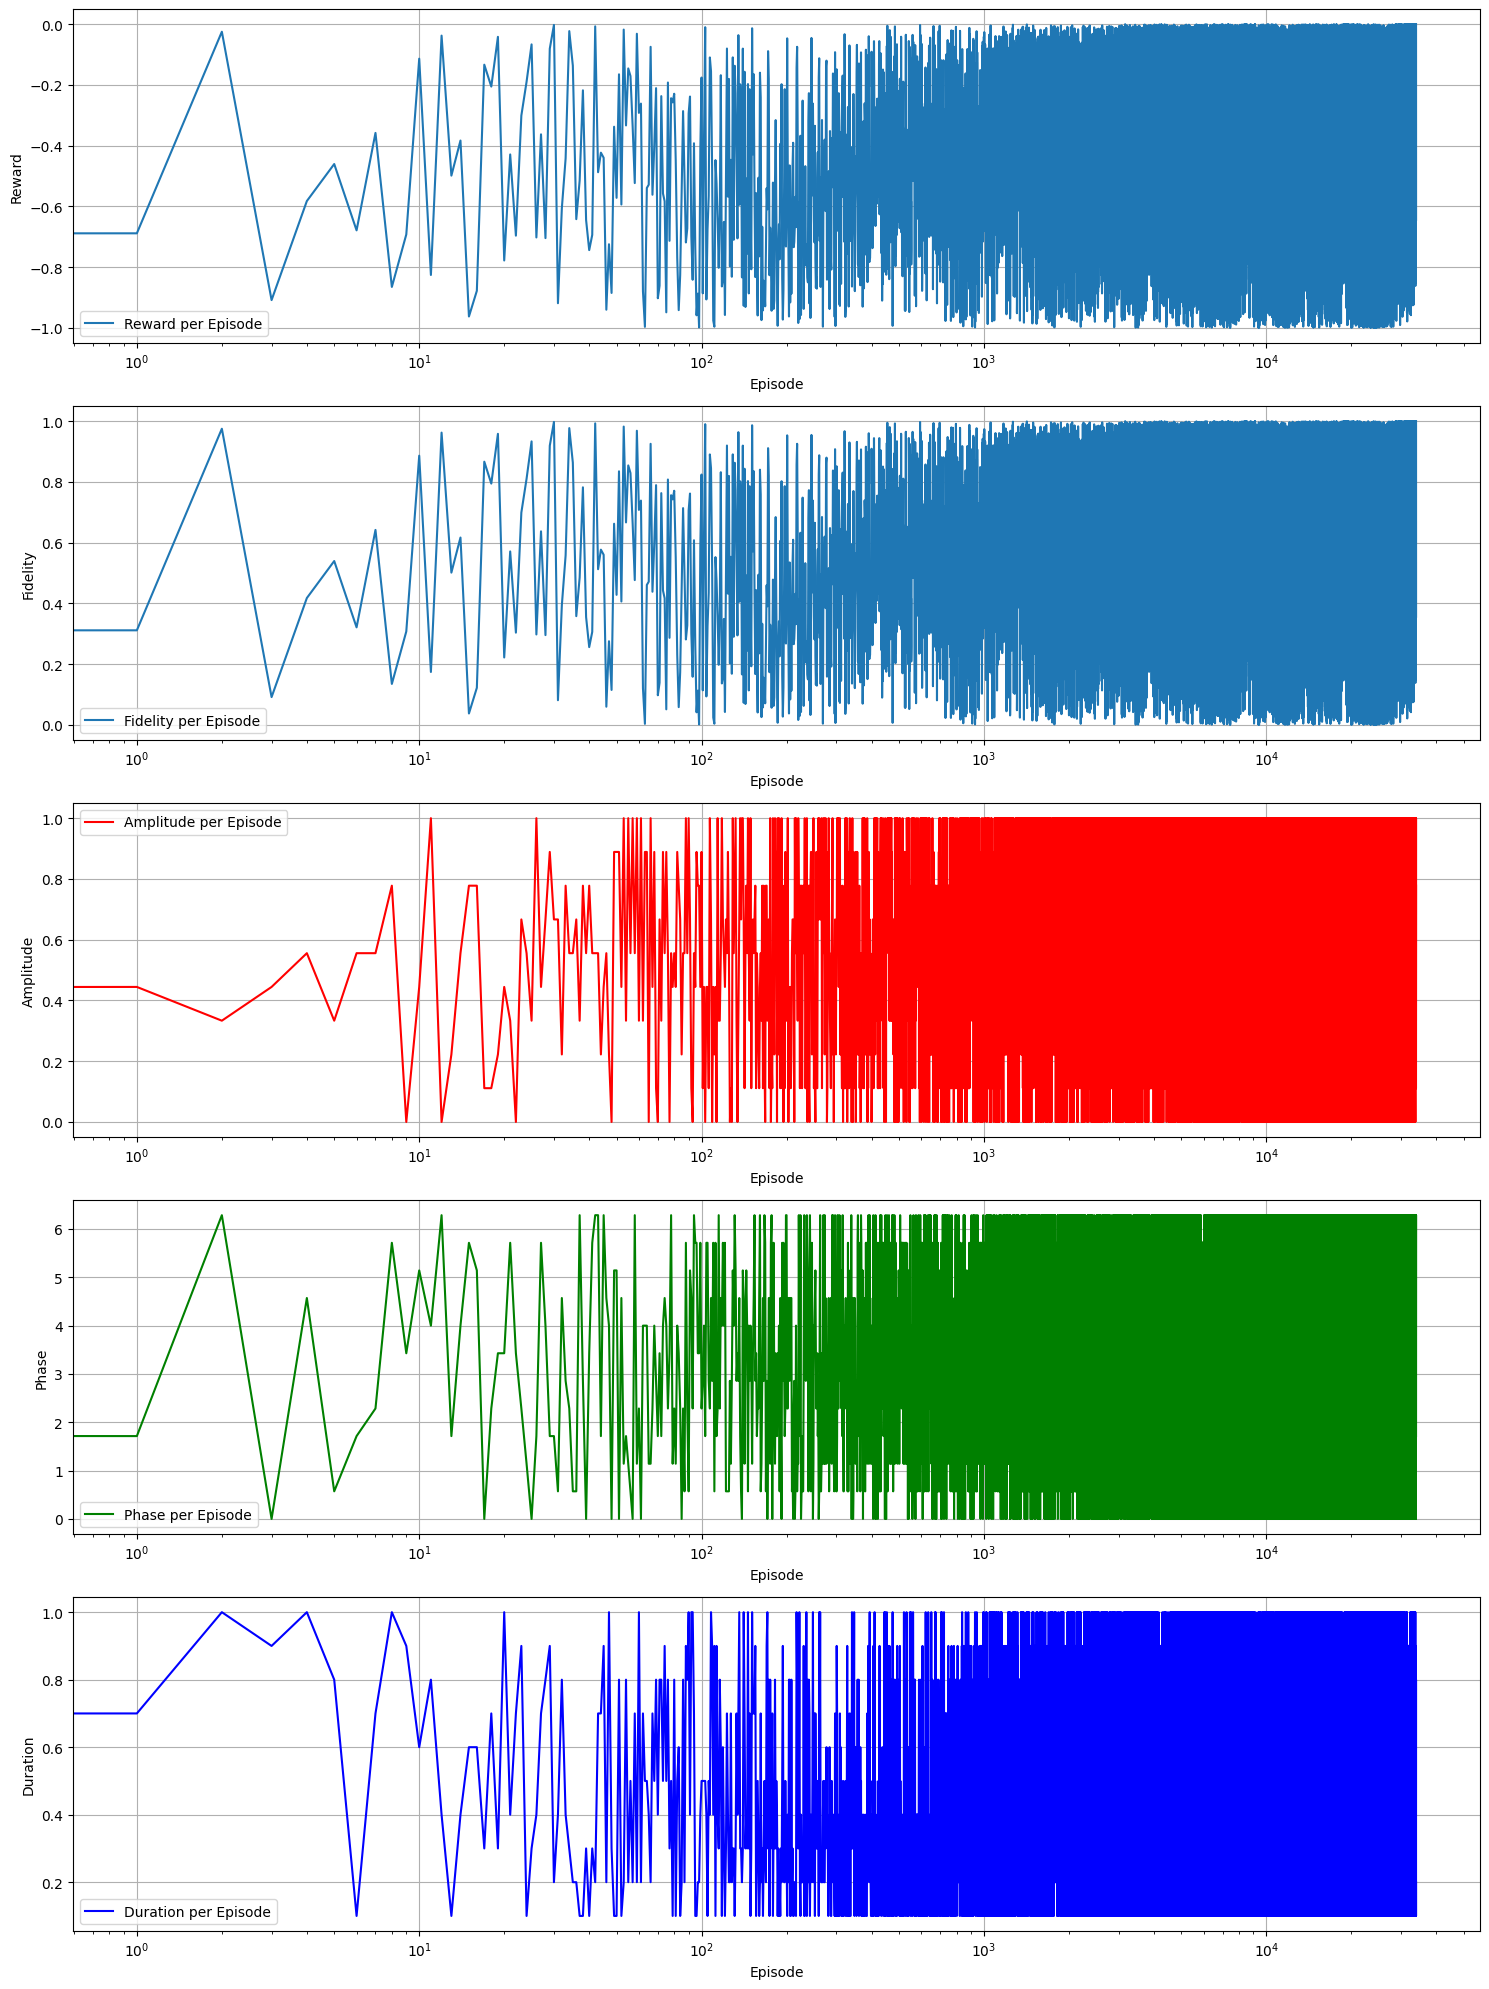

In [ ]:
# Plot Results
plot_results(
    reward_history,
    fidelity_history,
    amplitude_history,
    phase_history,
    duration_history,
    False,
)

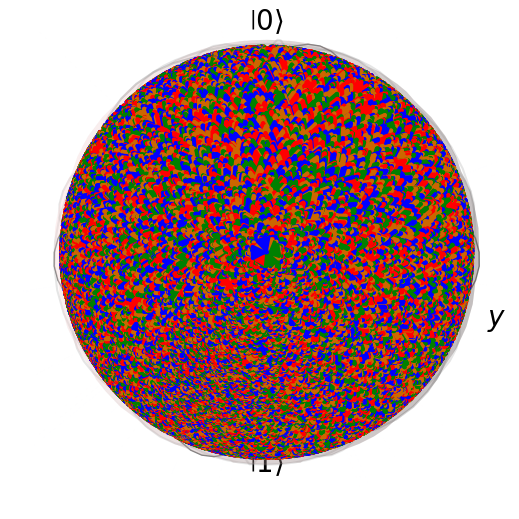

In [ ]:
# Plot Bloch Sphere
plot_bloch_sphere_trajectory(state_history)

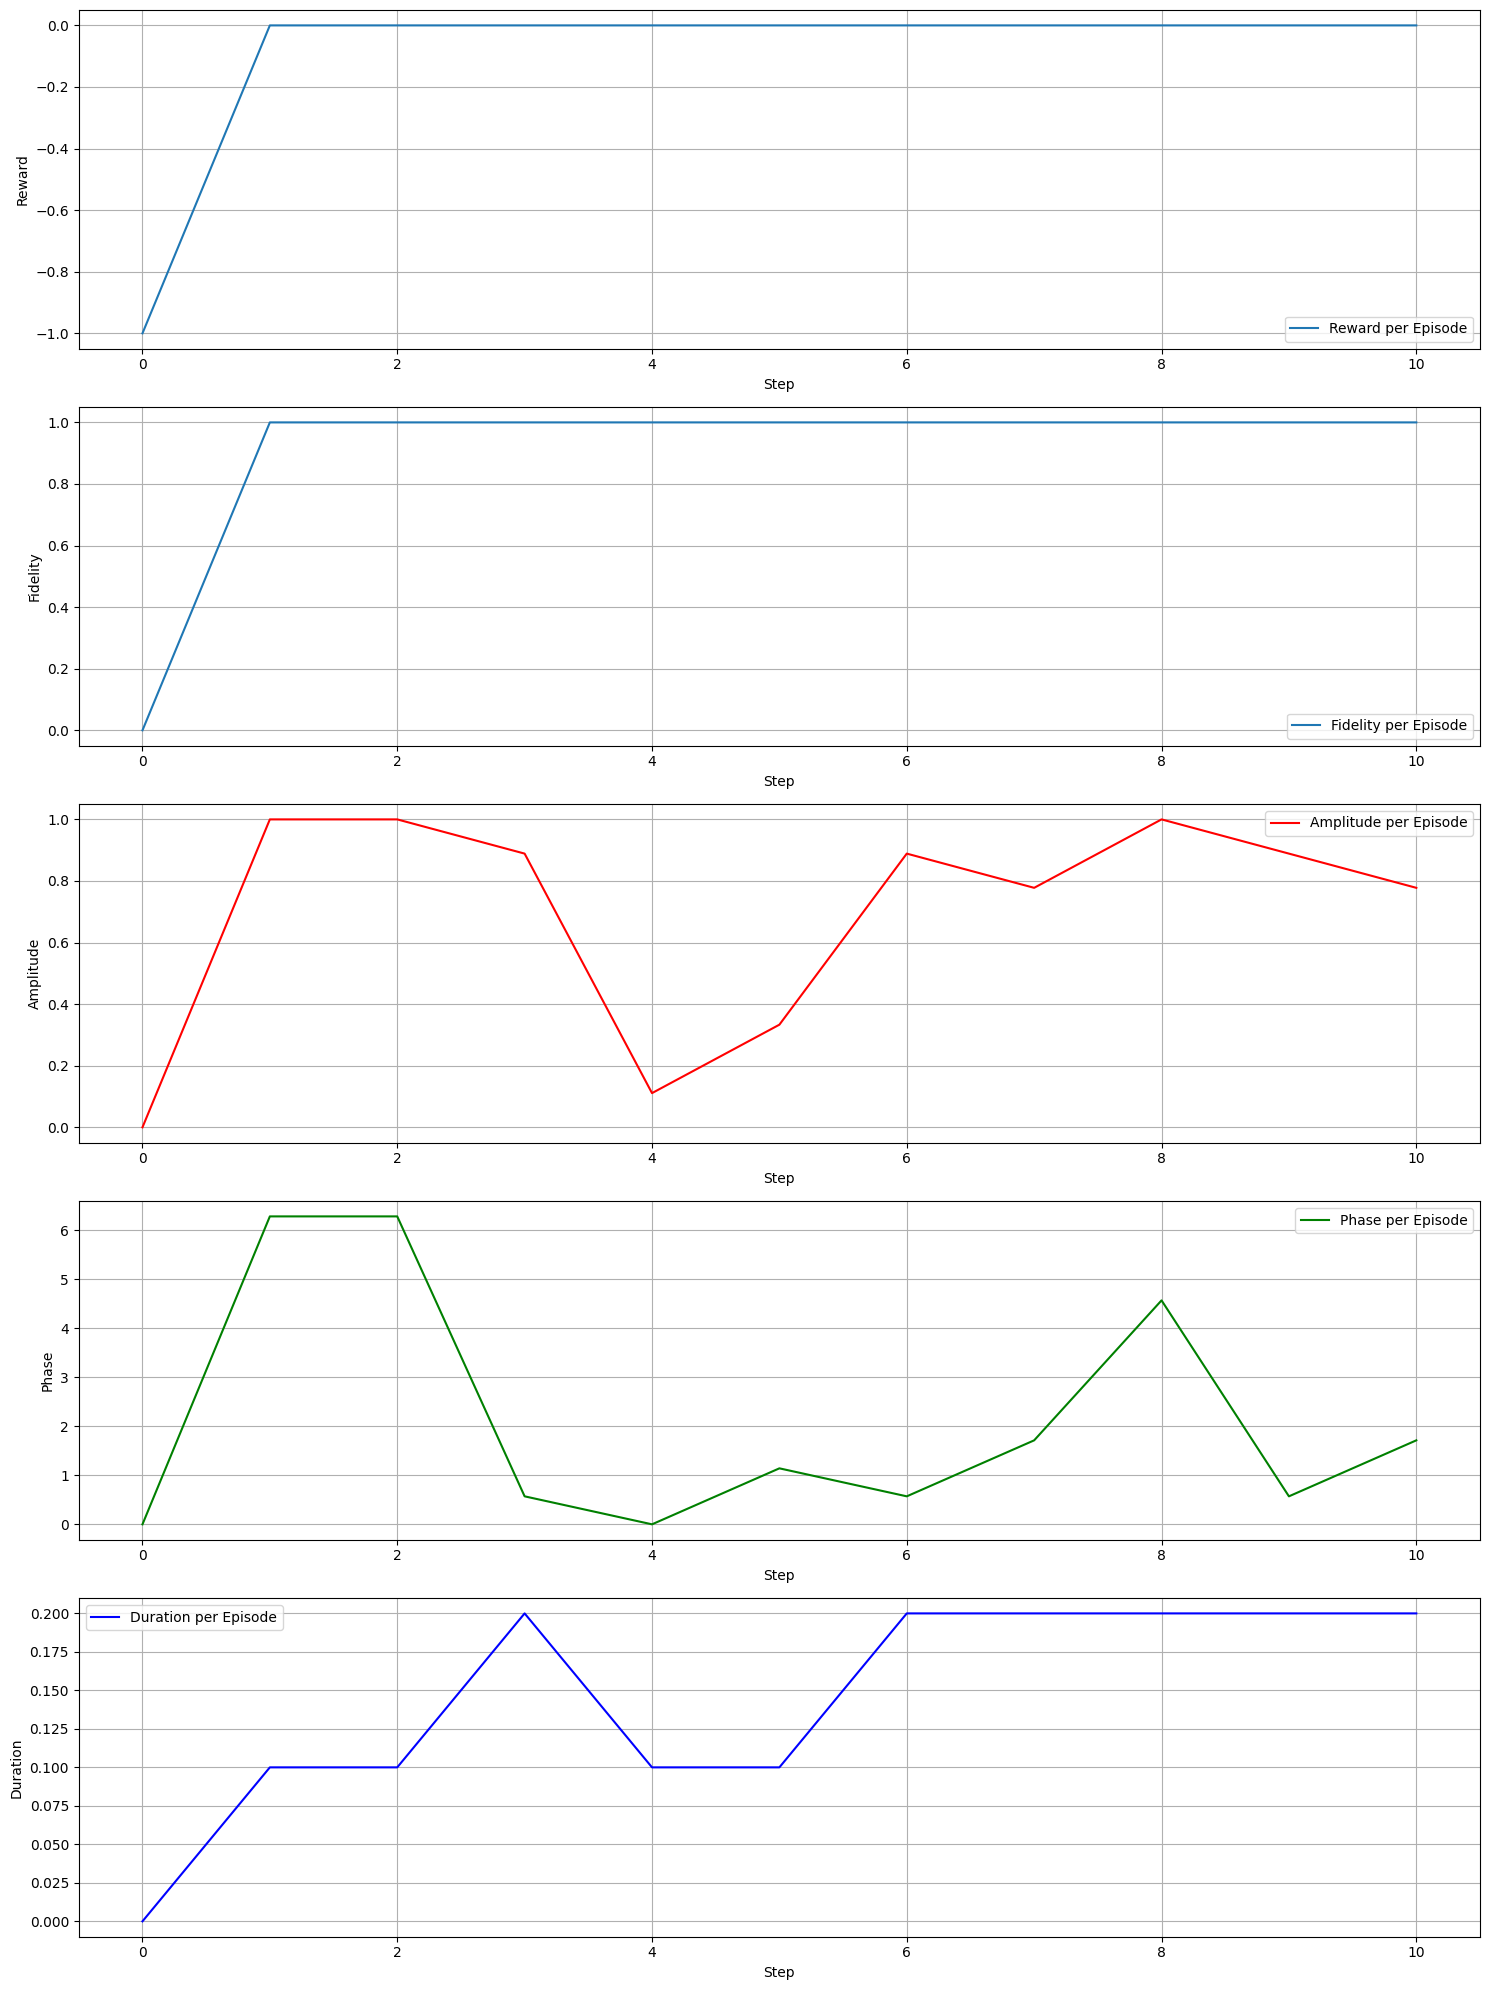

In [ ]:
# Plot Last Episode Results
plot_results(
    env.reward_episode,
    env.fidelity_episode,
    env.amplitude_episode,
    env.phase_episode,
    env.duration_episode,
    True,
)

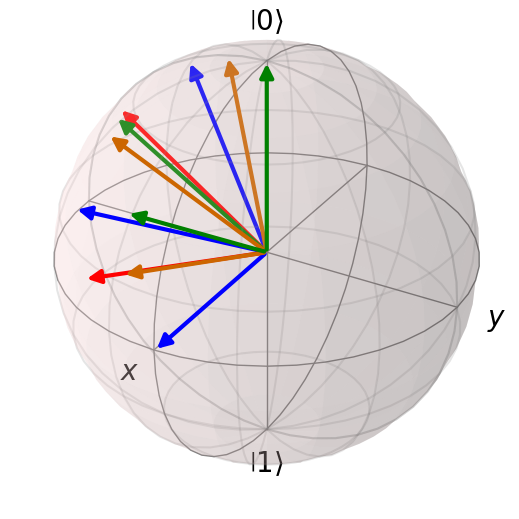

In [ ]:
# Plot Last Episode Trajectory
plot_bloch_sphere_trajectory(env.state_episode)

T-Gate

In [ ]:
env = QuantumGateEnv(gate="T")
agent = DQNAgent(env.state_size, env.action_size)

(
    reward_history,
    fidelity_history,
    state_history,
    amplitudes_history,
    phases_history,
    durations_history,
) = train_agent(agent, env, EPISODES, TARGET_UPDATE, FIDELITY_THRESHOLD, PATIENCE)

Episode: 0/200000,  Reward: -0.99949, Fidelity: 0.00051,  Epsilon: 1.00000
Episode: 2000/200000,  Reward: -0.23991, Fidelity: 0.76009,  Epsilon: 0.00010
Episode: 4000/200000,  Reward: -0.00424, Fidelity: 0.99576,  Epsilon: 0.00010
Episode: 6000/200000,  Reward: -0.31929, Fidelity: 0.68071,  Epsilon: 0.00010
Episode: 8000/200000,  Reward: -0.54907, Fidelity: 0.45093,  Epsilon: 0.00010
Episode: 10000/200000,  Reward: -0.45159, Fidelity: 0.54841,  Epsilon: 0.00010
Episode: 12000/200000,  Reward: -0.01078, Fidelity: 0.98922,  Epsilon: 0.00010
Episode: 14000/200000,  Reward: -0.00491, Fidelity: 0.99509,  Epsilon: 0.00010
Episode: 16000/200000,  Reward: -0.20718, Fidelity: 0.79282,  Epsilon: 0.00010
Episode: 18000/200000,  Reward: -0.14395, Fidelity: 0.85605,  Epsilon: 0.00010
Episode: 20000/200000,  Reward: -0.04177, Fidelity: 0.95823,  Epsilon: 0.00010
Episode: 22000/200000,  Reward: -0.91055, Fidelity: 0.08945,  Epsilon: 0.00010
Early stopping triggered. Achieved fidelity: 1.00000, Episod

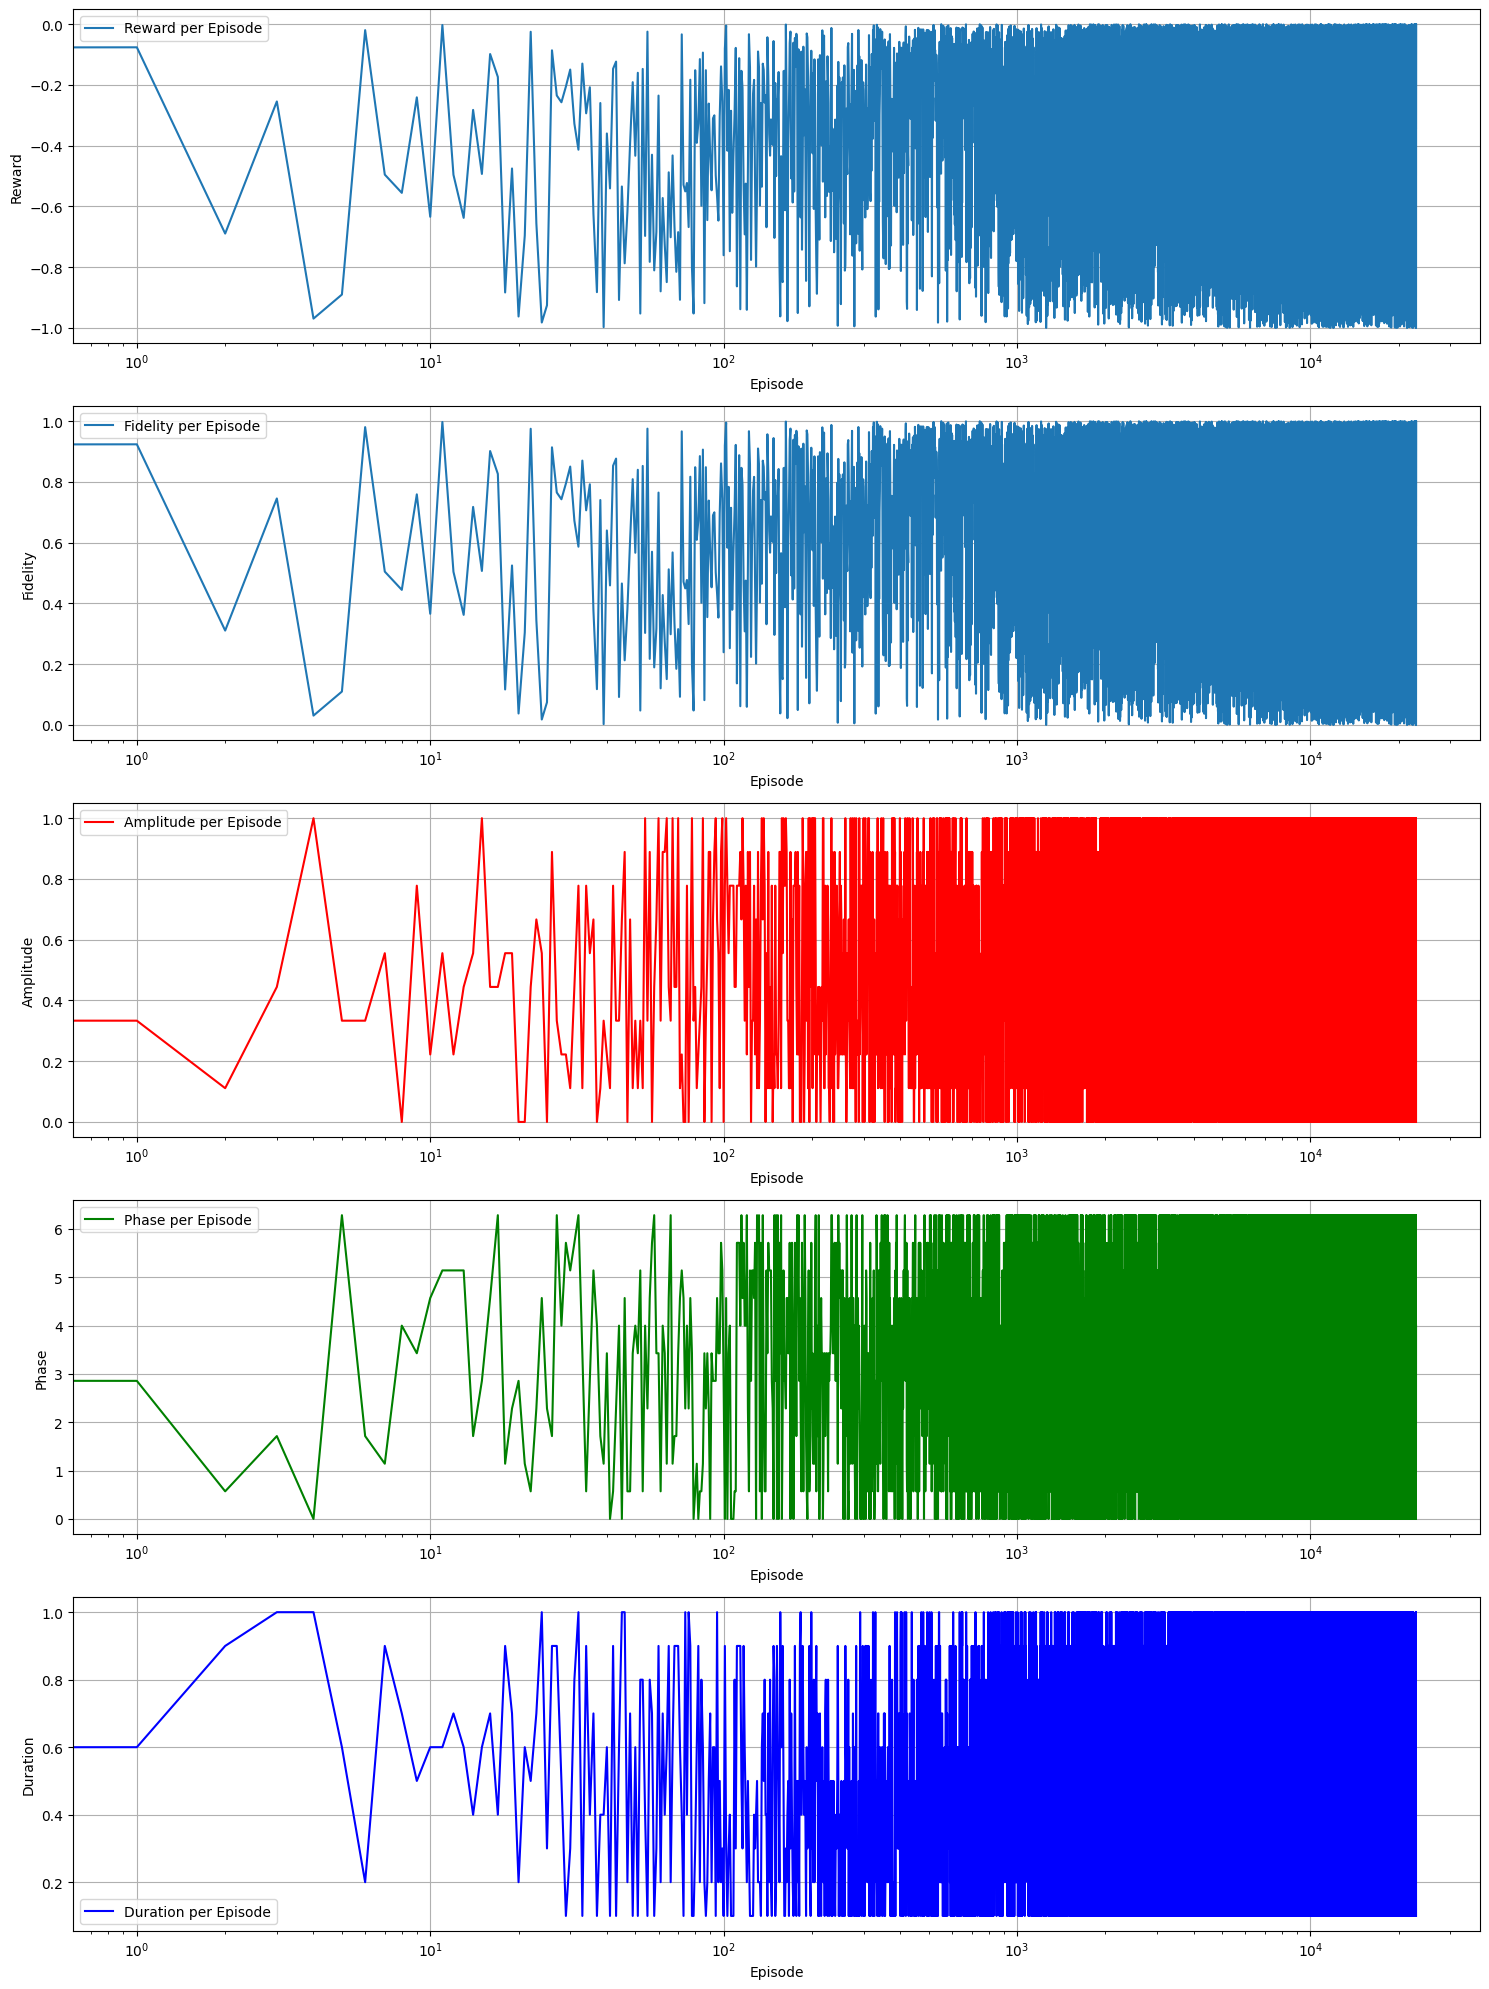

In [ ]:
plot_results(
    reward_history,
    fidelity_history,
    amplitudes_history,
    phases_history,
    durations_history,
    False,
)

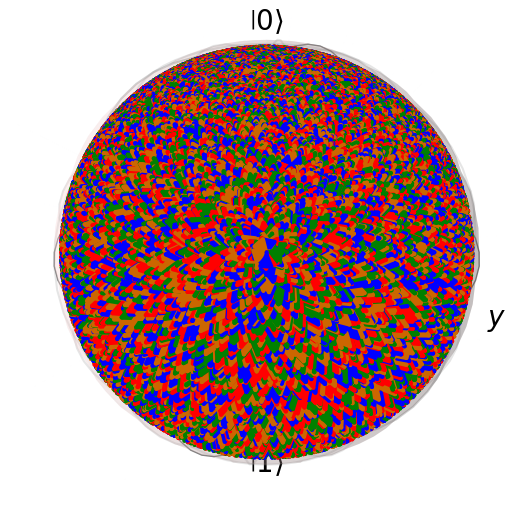

In [ ]:
plot_bloch_sphere_trajectory(state_history)

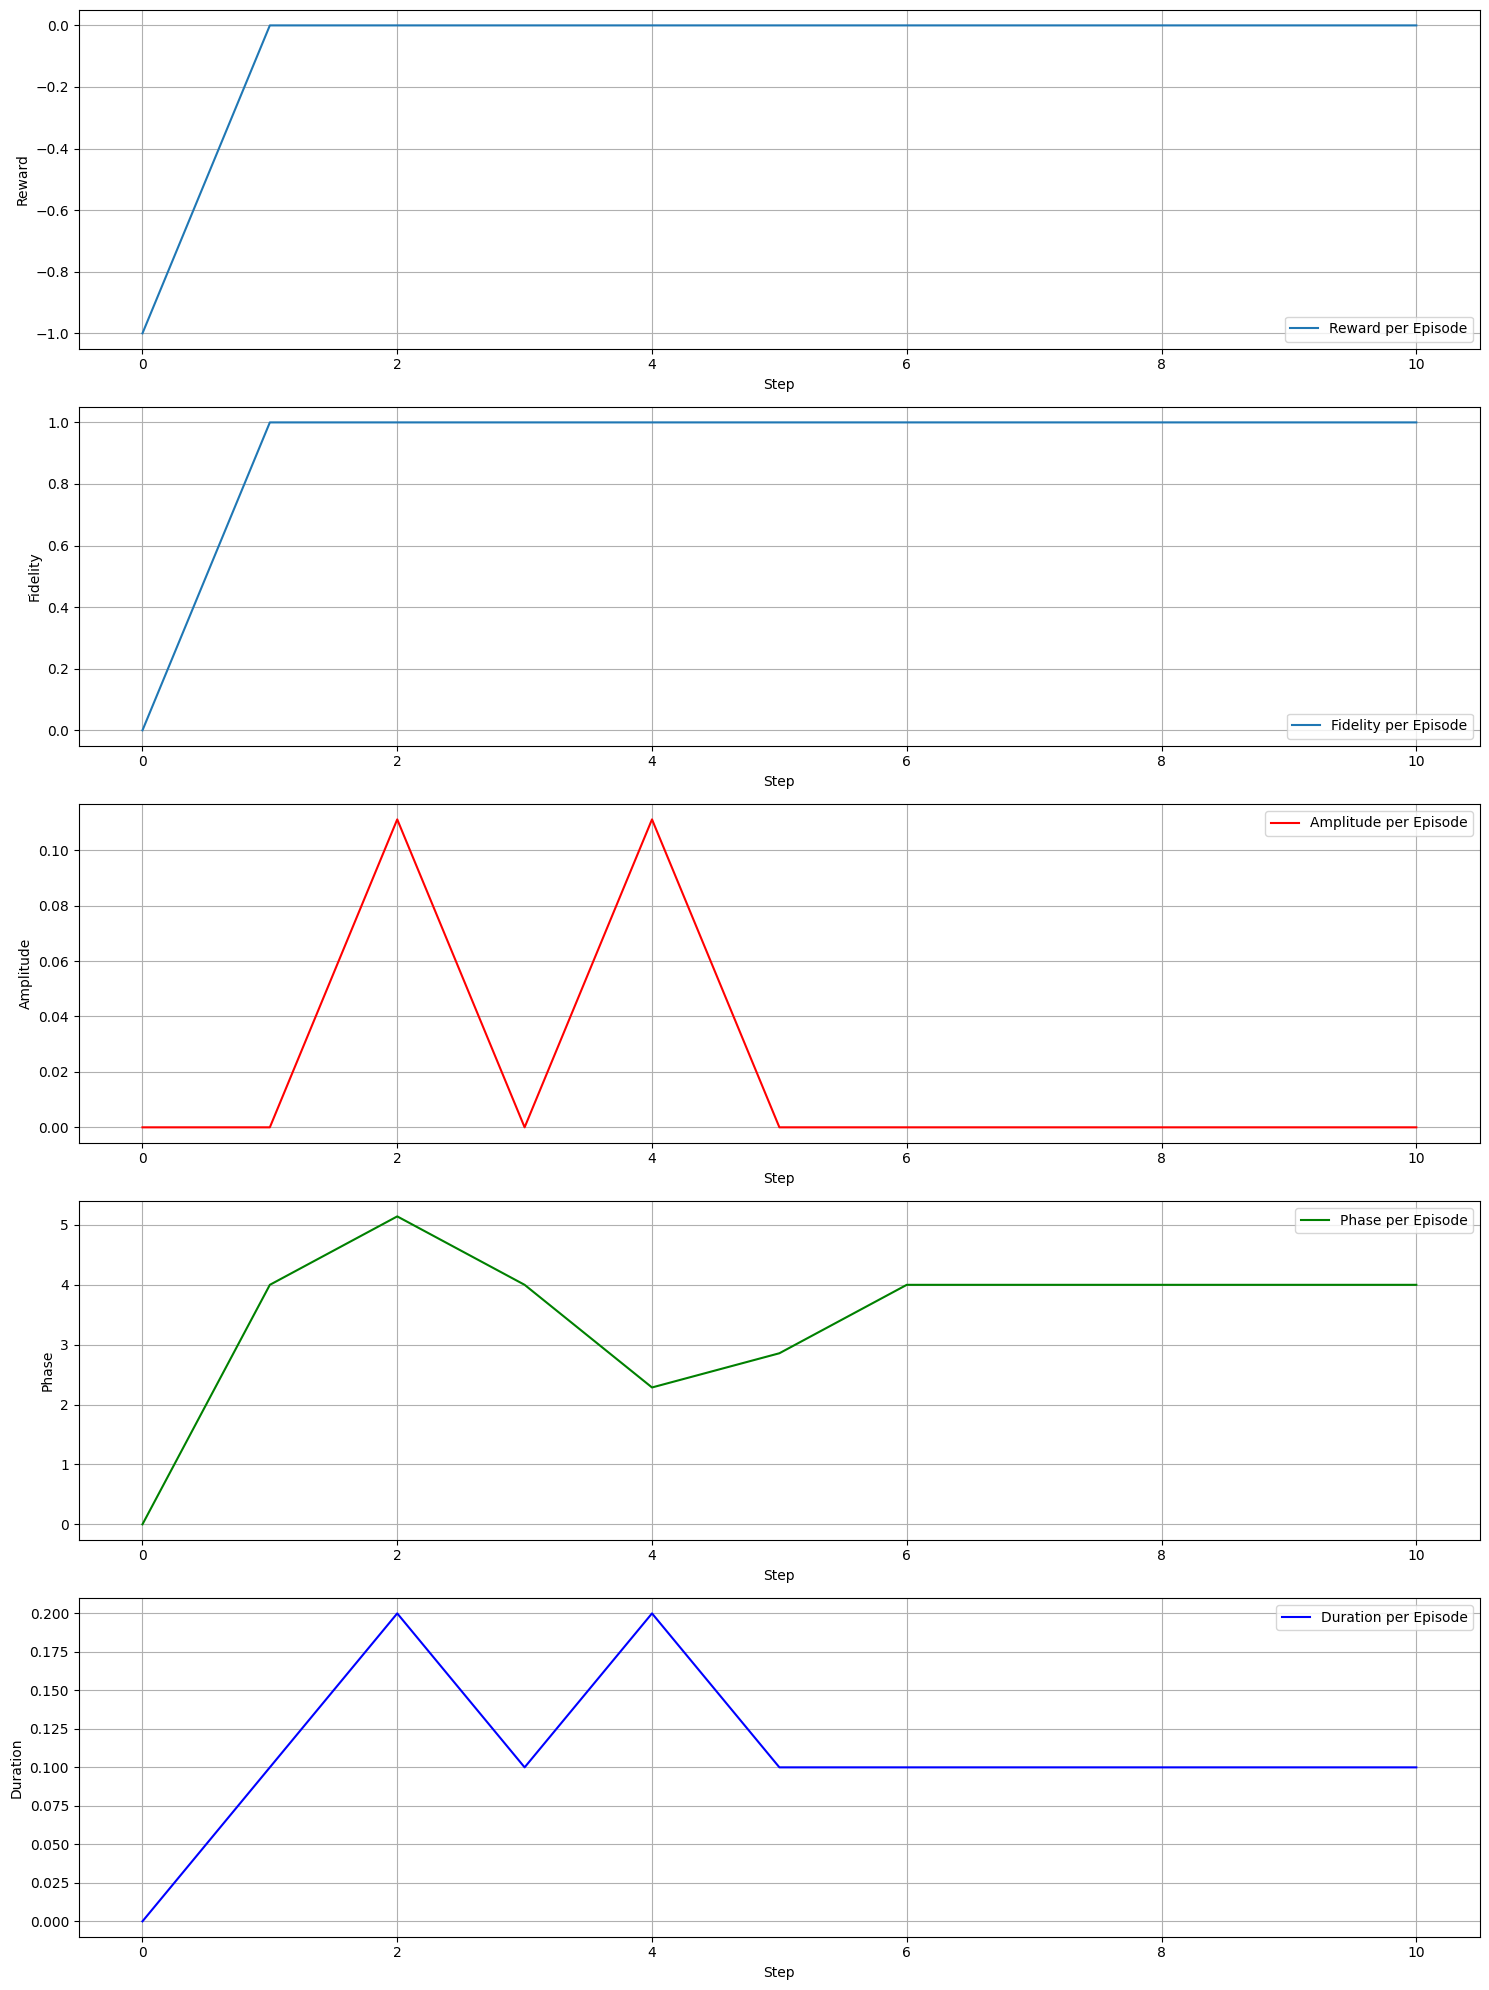

In [ ]:
plot_results(
    env.reward_episode,
    env.fidelity_episode,
    env.amplitude_episode,
    env.phase_episode,
    env.duration_episode,
    True,
)

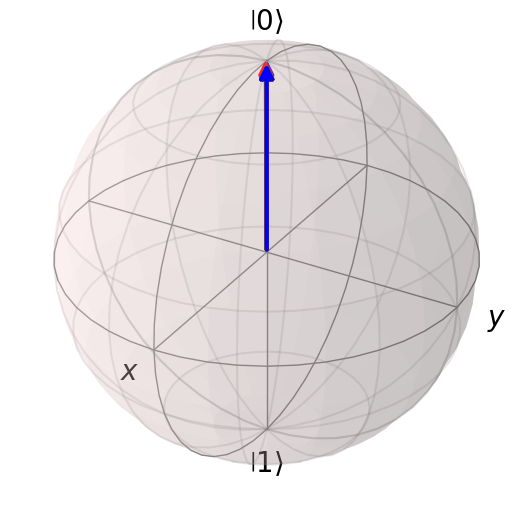

In [ ]:
plot_bloch_sphere_trajectory(env.state_episode)

CNOT-Gate

In [ ]:
env = QuantumGateEnv(gate="CNOT")
agent = DQNAgent(env.state_size, env.action_size)

if torch.__version__ >= "2.0.0":
    agent.model = torch.compile(agent.model)
    agent.target_model = torch.compile(agent.target_model)

(
    reward_history,
    fidelity_history,
    state_history,
    amplitudes_history,
    phases_history,
    durations_history,
) = train_agent(agent, env, EPISODES, TARGET_UPDATE, FIDELITY_THRESHOLD, PATIENCE)

Episode: 0/200000,  Reward: -0.57954, Fidelity: 0.42046,  Epsilon: 1.00000
Episode: 2000/200000,  Reward: -0.20379, Fidelity: 0.79621,  Epsilon: 0.00010
Episode: 4000/200000,  Reward: -0.27837, Fidelity: 0.72163,  Epsilon: 0.00010
Episode: 6000/200000,  Reward: -0.83698, Fidelity: 0.16302,  Epsilon: 0.00010
Episode: 8000/200000,  Reward: -0.08227, Fidelity: 0.91773,  Epsilon: 0.00010
Episode: 10000/200000,  Reward: -0.48506, Fidelity: 0.51494,  Epsilon: 0.00010
Episode: 12000/200000,  Reward: -0.07876, Fidelity: 0.92124,  Epsilon: 0.00010
Episode: 14000/200000,  Reward: -0.39619, Fidelity: 0.60381,  Epsilon: 0.00010
Episode: 16000/200000,  Reward: -0.13102, Fidelity: 0.86898,  Epsilon: 0.00010
Episode: 18000/200000,  Reward: -0.61767, Fidelity: 0.38233,  Epsilon: 0.00010
Episode: 20000/200000,  Reward: -0.19716, Fidelity: 0.80284,  Epsilon: 0.00010
Episode: 22000/200000,  Reward: -0.07678, Fidelity: 0.92322,  Epsilon: 0.00010
Episode: 24000/200000,  Reward: -0.09533, Fidelity: 0.90467,

In [ ]:
def plot_q_sphere(states):
    """
    Plot the QSphere for a list of quantum states.

    Parameters:
    states: list of quantum states in the form of complex-valued numpy arrays
    """
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")

    # Draw the QSphere (Bloch sphere)
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))

    ax.plot_surface(x, y, z, color="r", alpha=0.1)

    # Plot the initial state with a distinct color
    initial_state = states[0]
    alpha_init = initial_state[0]
    beta_init = initial_state[1]

    theta_init = 2 * np.arccos(np.abs(alpha_init))  # Polar angle
    phi_init = np.angle(beta_init) - np.angle(alpha_init)  # Azimuthal angle

    x_init = np.sin(theta_init) * np.cos(phi_init)
    y_init = np.sin(theta_init) * np.sin(phi_init)
    z_init = np.cos(theta_init)

    ax.plot([0, x_init], [0, y_init], [0, z_init], color="black", linestyle="--")
    ax.scatter(x_init, y_init, z_init, color="black", s=100)

    # Plot the other states
    for state in states[1:]:
        alpha = state[0]
        beta = state[1]

        # Calculate spherical coordinates
        theta = 2 * np.arccos(np.abs(alpha))  # Polar angle
        phi = np.angle(beta) - np.angle(alpha)  # Azimuthal angle

        # Cartesian coordinates
        x = np.sin(theta) * np.cos(phi)
        y = np.sin(theta) * np.sin(phi)
        z = np.cos(theta)

        # Color based on phase
        color = cm.hsv((phi + np.pi) / (2 * np.pi))

        ax.plot([0, x], [0, y], [0, z], color=color)
        ax.scatter(x, y, z, color=color, s=100)

    # Set axis limits
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])

    # Set labels
    ax.set_xlabel("Re(α)")
    ax.set_ylabel("Im(α)")
    ax.set_zlabel("Re(β)")
    plt.show()

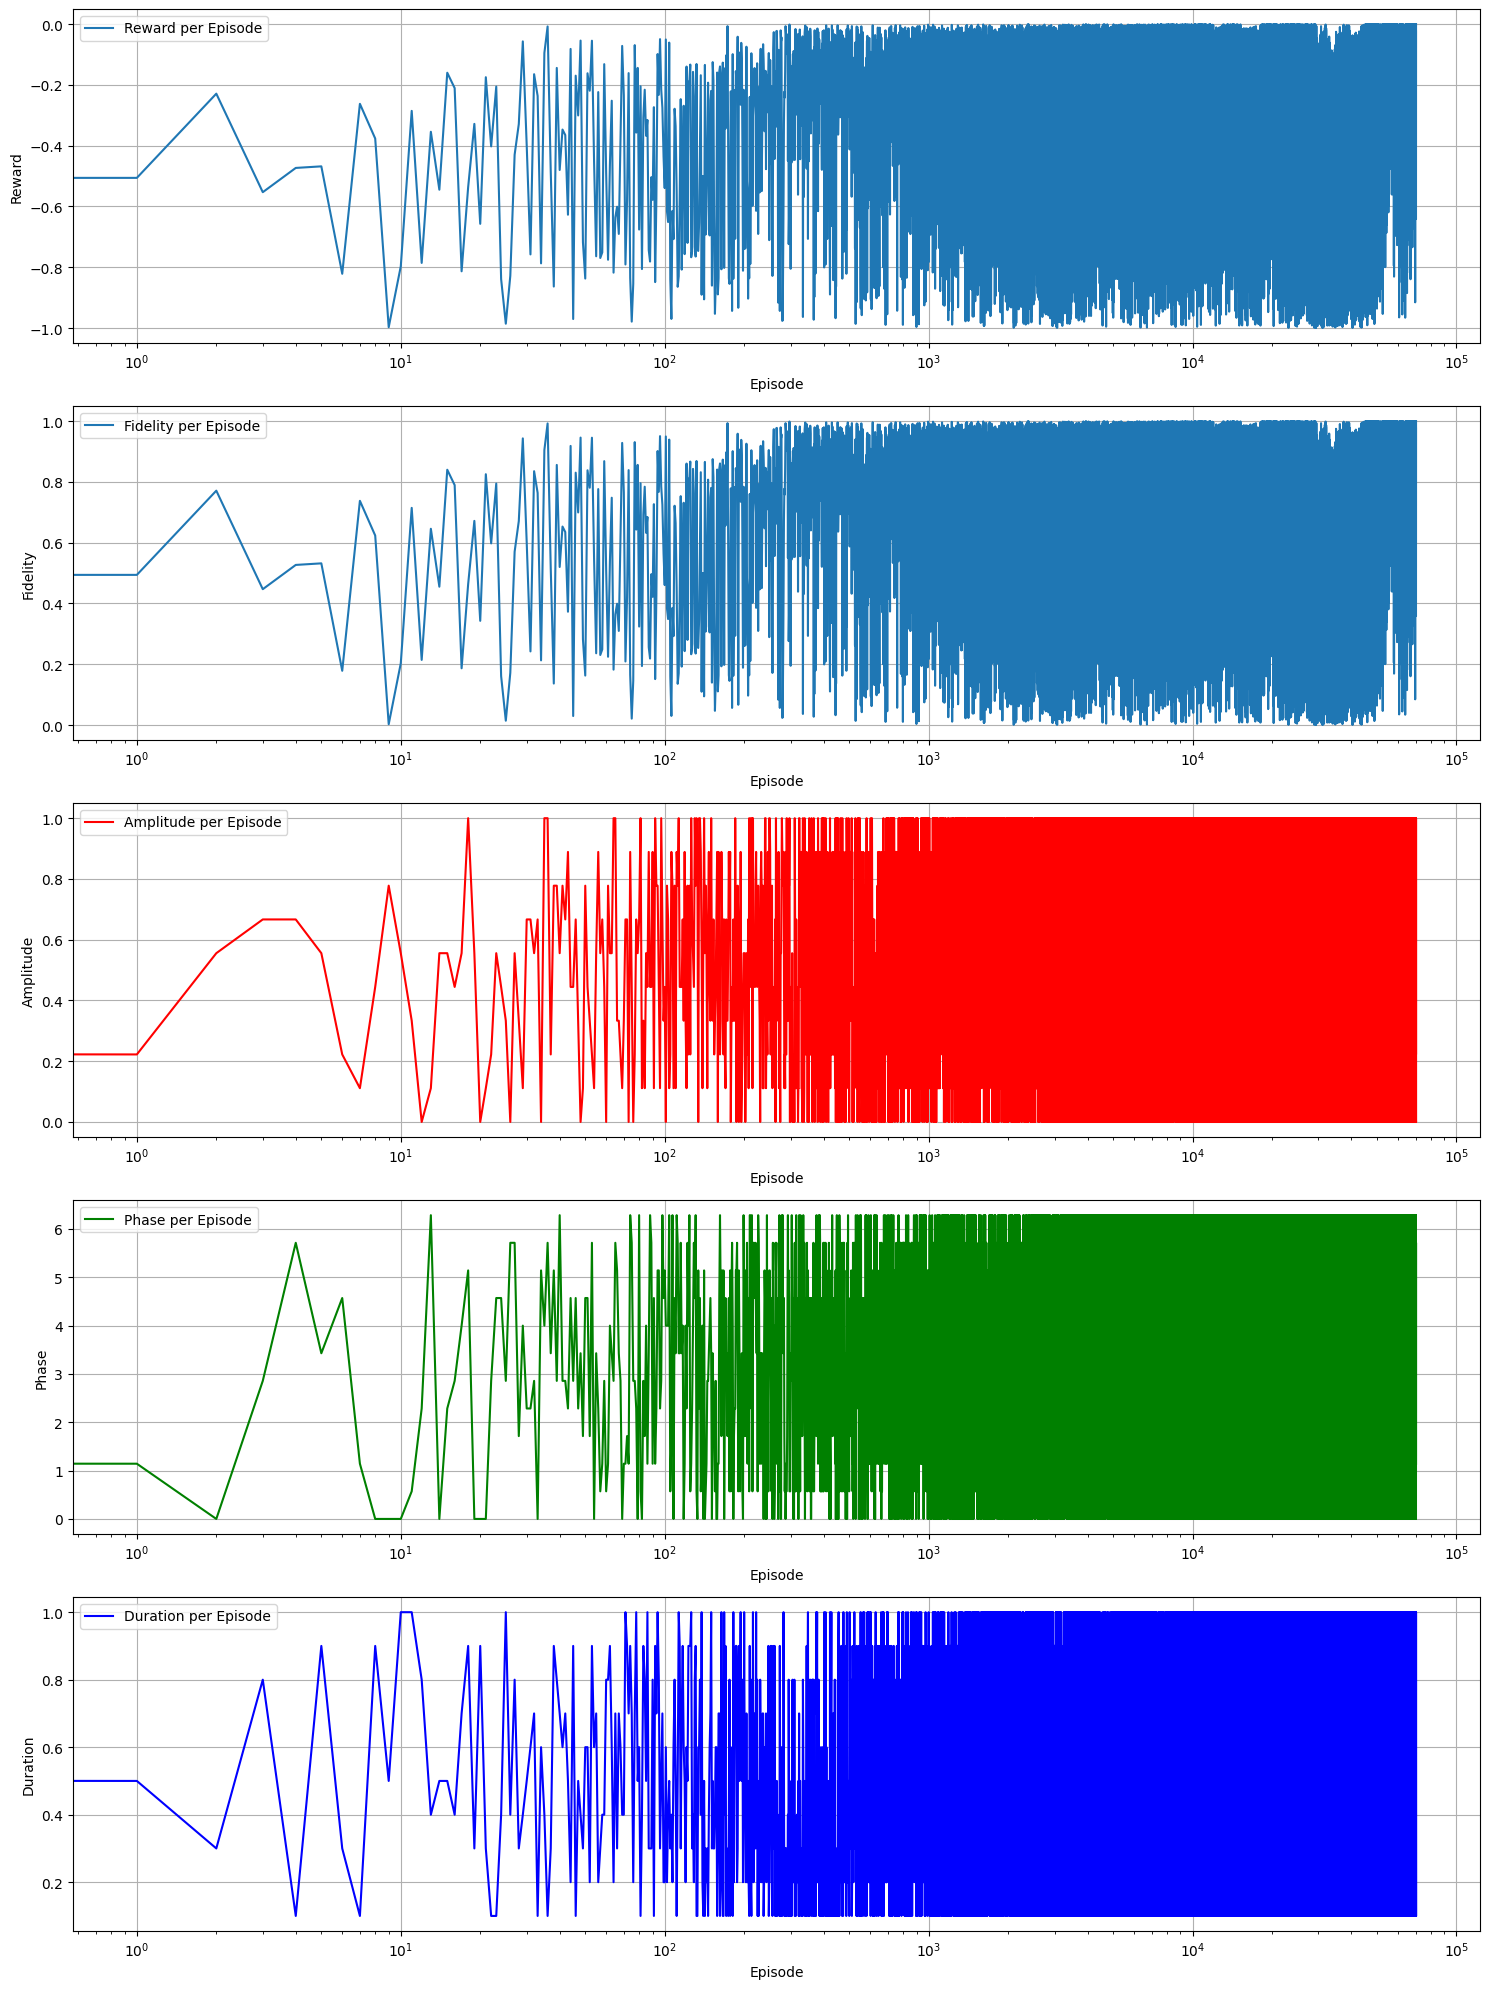

In [ ]:
plot_results(
    reward_history,
    fidelity_history,
    amplitudes_history,
    phases_history,
    durations_history,
    False,
)

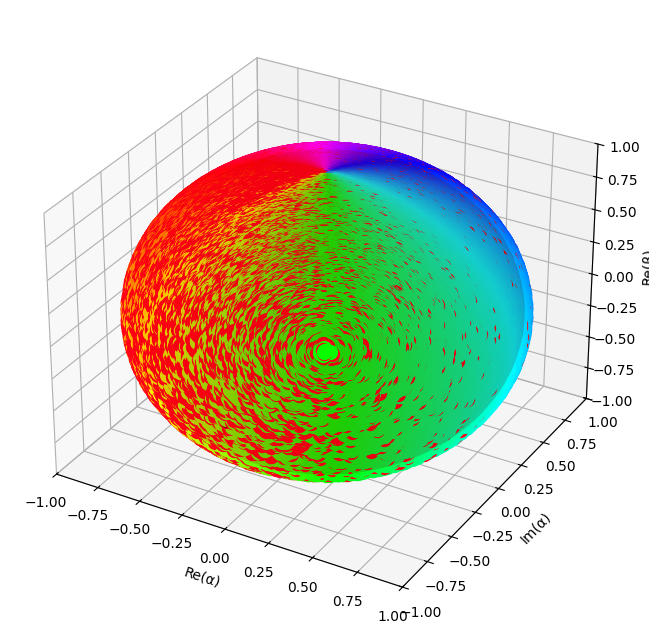

In [ ]:
plot_q_sphere(state_history)

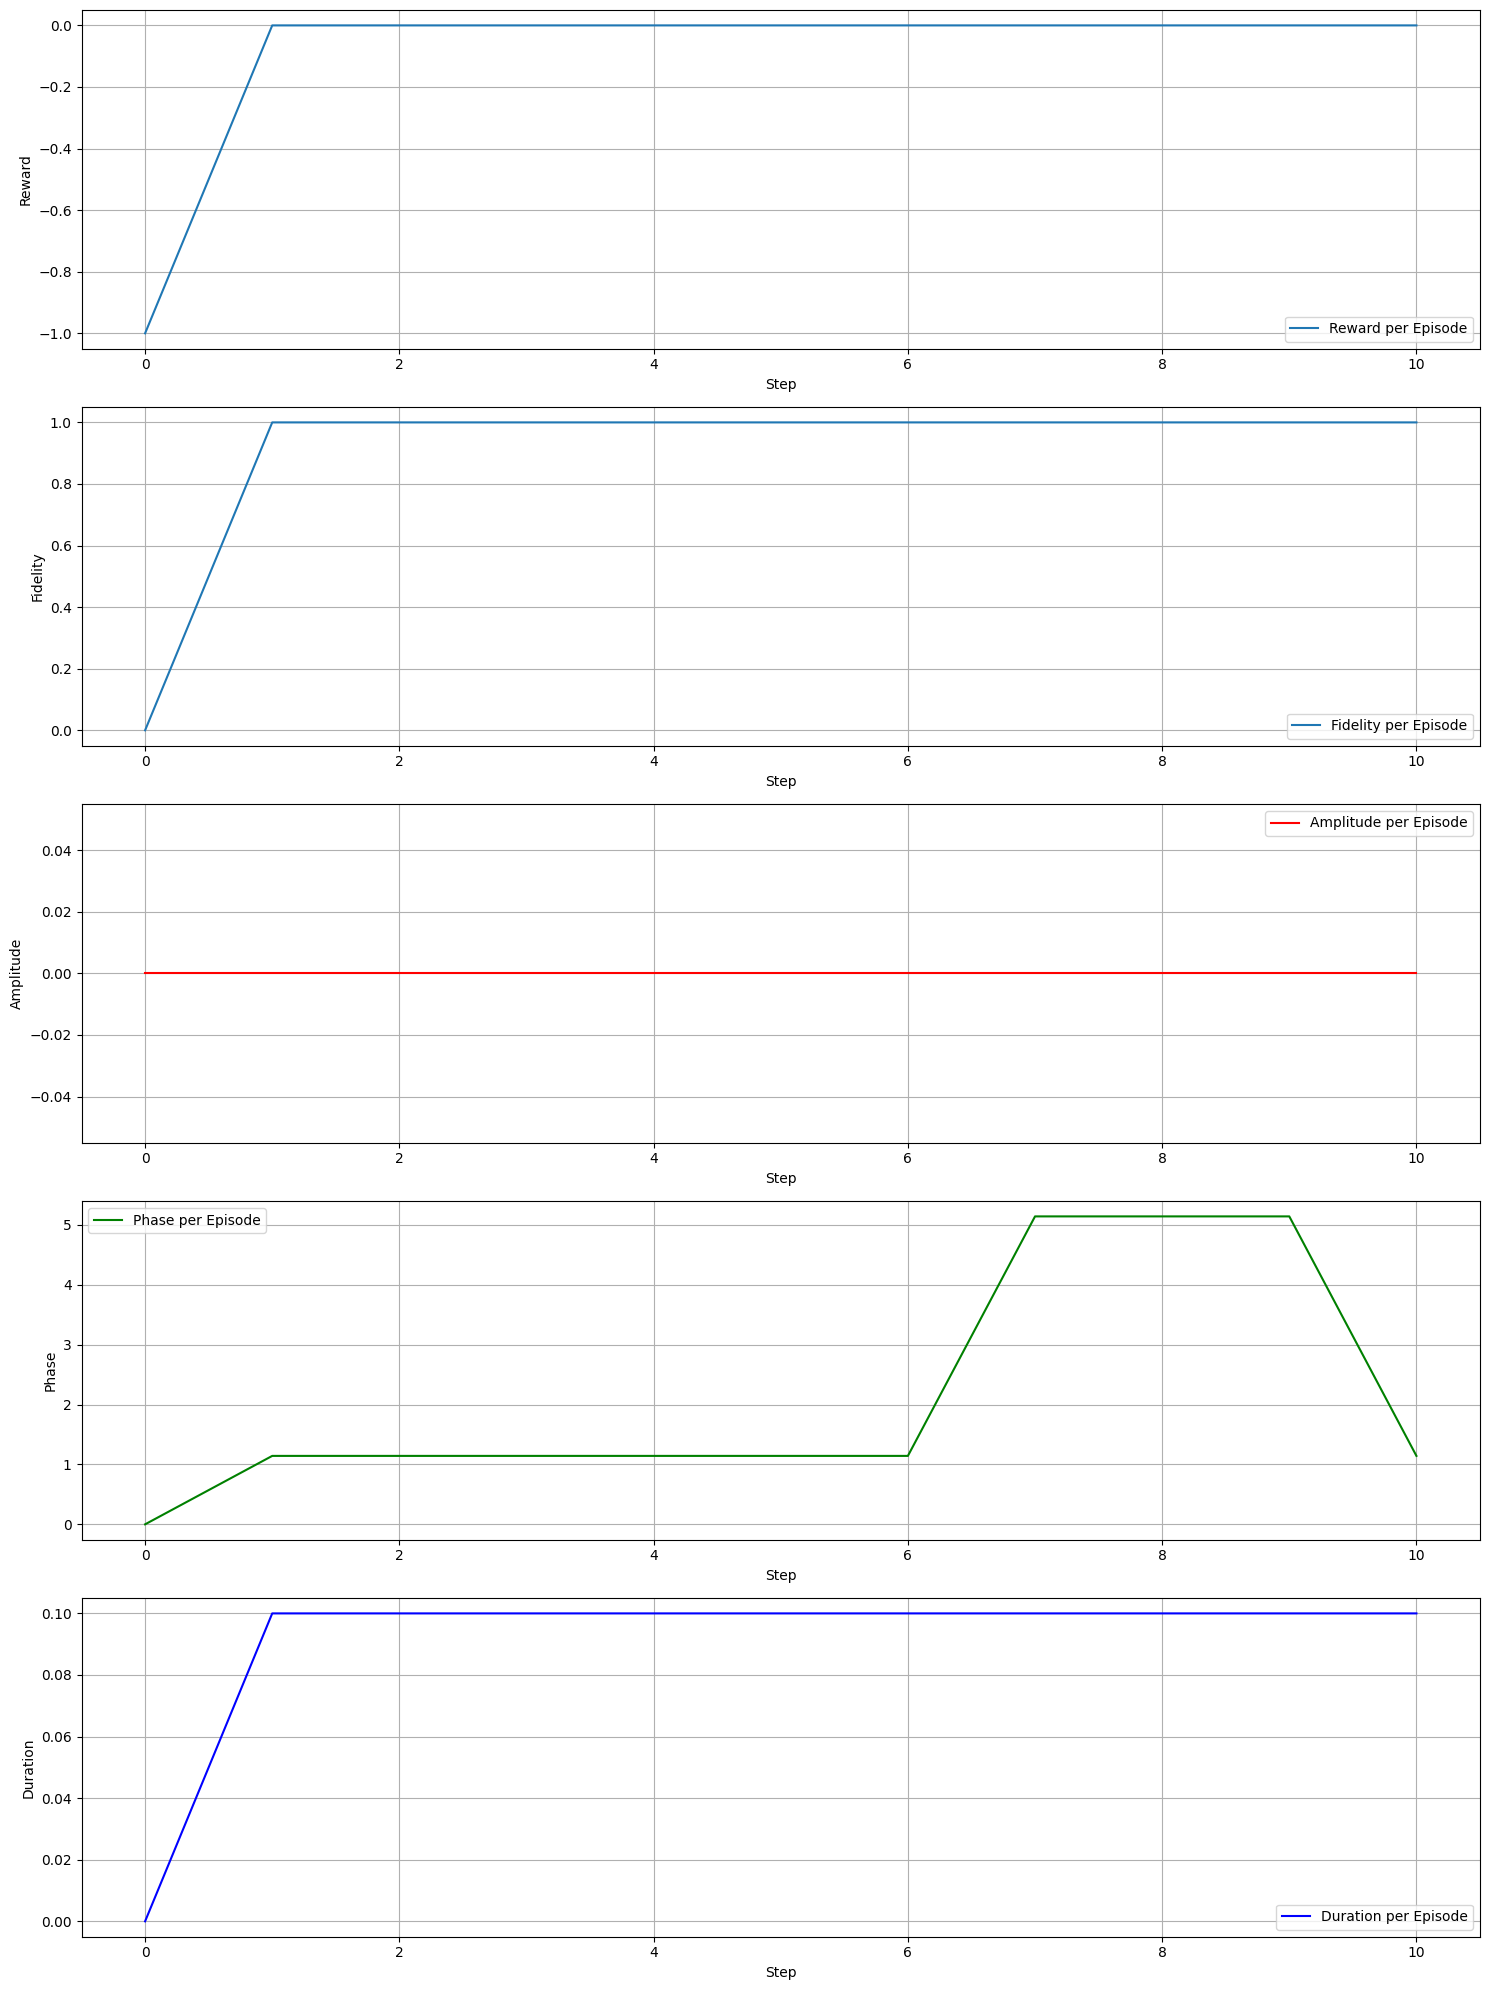

In [ ]:
plot_results(
    env.reward_episode,
    env.fidelity_episode,
    env.amplitude_episode,
    env.phase_episode,
    env.duration_episode,
    True,
)

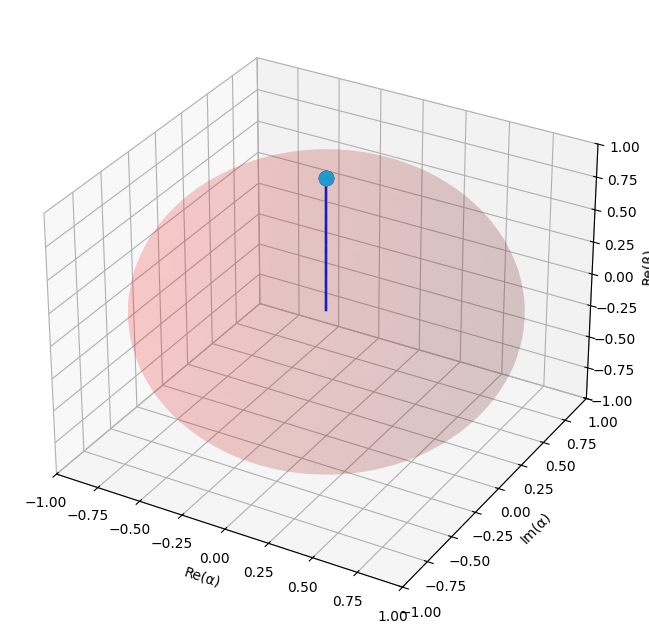

In [ ]:
plot_q_sphere(env.state_episode)